# Prelimanary information






## Introduction and motivation



Studies have shown that not all people are equally susceptible to COVID-19. We also know that the types of people living in different counties across the U.S. can vary greatly. We wanted to pull information on types of people that were more at risk and see if we could group counties into clusters that were similarly at risk so those counties could know how susceptible their average population was. This included biological, demographic, and socioeconomic factors that would help determine a persons susceptibility to COVID-19. We also wanted to use mobility data to see how social distancing was affecting these groups of counties to see which counties were most affected by reduced mobility. The end goal would be to help counties know what level of social distancing measures they should put into place and when they could begin to relax those measures to improve the economy. 

We used publicly available county-specific data to pull biological, demographic, and socioeconomic factors. We built an API to query for specific information from the American Community Survey and also used data provided by another research group(1) that pulled data from Area Health Resource Files, Centers for Desease Control and Prevention Atlas file, National Center for Health Statistics, and RWJF Community Health Rankings.

We wanted to focus on pulling data that was related to findings on factors that affect a communities susceptibility to COVID-19. For example Age and pre-existing health conditions have been reported as important factors in how severe the affects of COVID-19 are (4,5). Demographic factors like population density, living arrangements (nursing homes, prisons, etc), household size and composition (grandparents living with grandchildren), affect transmission rates at the county level (6,7). there are reports that suggest Black Americans account for a larger percentage of case counts than others given their total population (2,3).

We realize that our data is not comprehensive and that a lot of our data will be highly correlated like percentage of people over 25 with a bachelors or higher. This could be a very important indicator as there is a smaller chance these people will be living in poverty and they have higher chances of having access to health care and healthy foods for an improved immune system. Though these are two other features that we have already included in our dataset. They are also more likely to have jobs and have access to internet to work from home which are two other features that we use in our county data. Despite this, we used unsupervised clustering techniques including, K-means and DBSCAN to cluster these counties together using our 140 or so features of each county.

With our data clustered we were able to look at how each cluster of counties was affected by the average change in mobility in each county. We did this by plotting the normalized rate of covid-19 cases vs the percent change in mobility on a scatter plot and making linear models for each cluster of counties to see the relationship between change in mobility and change in rate of covid-19 cases. 

Import Statements

In [1]:
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns; sns.set(color_codes=True)

import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import math
from datetime import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing and aggregation

## Census preprocessing with some plots


Covid-19 affects various groups of people differently. So it is important that we understand what counties contain the roups that are most at risk and create models that group counties that are similar together so we can make conclusions that will provide insights that are specific to each county. Age and poverty play a role in how people get affected by Covid-19. A study in China found that fatality rate from COVID-19 was highest amond the elderly. In the United States another study found that 80% of deaths were amond adults 65 and older. In New York hospitalization rates were higher in high-poverty areas. Lack of Health Insurance and pre-existing conditions also play a big role in how likely someone is to be affected and how severe. A Study in china found that people with cardiovascular disease, diabetes, hypertension and respiratory diseases had a higher fatality rate from the disease. People withougt access to health insurance are less likely to get the care they need when having strong symptoms. Other factors like density and living conditions also play a role in how quikly the virus can spread.

For this reason we built an API to the American Community Survey that annually surveys about 1 percent of the population to update the characteristics of each county yearly. We used the most recent data available for a lot of the features we looked at which is 2018. We also used other data sources that others had put together to help us gather a total of about 140 features for each county. This data was used to create clusters of counties that were most similar.

In [0]:
import requests
# American Community Survey (annually ~1% pop) 
Host, dataset = 'https://api.census.gov/data', 'acs/acs5/profile' 

# Variables from api
get_vars = ['DP03_0062E', 'DP03_0009PE', 'DP03_0099PE', 'DP03_0128PE', 
            'DP04_0003PE', 'DP04_0089E', 'DP02_0067PE', 'DP02_0092PE',
            'DP02_0152PE', 'DP05_0018E', 'DP05_0033E', 'DP05_0078PE'] #M is margin of error
get_vars = ['NAME'] + get_vars
predicates = {}
predicates['get'] = ','.join(get_vars)
predicates['for'] = 'county:*'#'tract:*' gets all tracts
predicates['in'] = 'state:*'   #; county:*' 
# Initialize data frame collector
dfs = []
for year in range(2018, 2019): #get multiple years
    base_url = '/'.join([Host, str(year), dataset])
    r = requests.get(base_url, params=predicates)

    col_names = ['name', 'median_household_income', 'unemployment_rate', 
                 'no_health_insurance_p', 'income_below_poverty_p',
                 'vacant_housing_units_p', 'median_home_value',
                 "over25_bachelors_or_higher_p", 'pop_foreign_born_p',
                 'households_with_internet_subscription_p', 'median_age', 'total_population', 'black_african_american_p',
                 'state', 'county']
    df = pd.DataFrame(data=r.json()[1:], columns = col_names)
    # Add column to hold year value
    df['year'] = year
    dfs.append(df)
# Concatenate all data frames in collector
census_usa = pd.concat(dfs)

# Convert median household income to integer type
census_usa['median_household_income'] = census_usa.median_household_income.astype(int)

# Get names of indexes for which column median_household_income has value <0
indexNames = census_usa[ census_usa['median_household_income'] < 0 ].index
 
# Delete these row indexes from dataFrame
census_usa.drop(indexNames , inplace=True)

# create new geoid column that combines state and county to be able to merge with shape file later
geoid = census_usa.state + census_usa.county
census_usa.insert(13, "geoid", geoid, False)

#convert datatypes into correct types
census_usa['unemployment_rate'] = census_usa.unemployment_rate.astype(float)
census_usa['no_health_insurance_p'] = census_usa.no_health_insurance_p.astype(float)
census_usa['income_below_poverty_p'] = census_usa.income_below_poverty_p.astype(float)
census_usa['vacant_housing_units_p'] = census_usa.vacant_housing_units_p.astype(float)
census_usa['median_home_value'] = census_usa.median_home_value.astype(int)
census_usa["over25_bachelors_or_higher_p"] = census_usa.over25_bachelors_or_higher_p.astype(float)
census_usa['pop_foreign_born_p'] = census_usa.pop_foreign_born_p.astype(float)
census_usa['households_with_internet_subscription_p'] = census_usa.households_with_internet_subscription_p.astype(float)
census_usa['median_age'] = census_usa.median_age.astype(float)
census_usa['total_population'] = census_usa.total_population.astype(int)
census_usa['black_african_american_p'] = census_usa.black_african_american_p.astype(float)
census_usa['geoid'] = census_usa.geoid.astype(int)

In [0]:
# For plotting purposes we are taking out Alaska=02, Hawaii = 15, and Puerto Pico = 72
census_usa = census_usa[(census_usa.state!='02') & (census_usa.state!='15') & (census_usa.state!='72')].copy()

# get additional data from the Area Health Resources Files, Centers for Disease Control and Prevention Atlas file, 
# National Center for Health Statistics, and RWJF Community Health Rankings
additional_data = pd.read_csv('https://raw.githubusercontent.com/GabrielBG010/Covid-County-Clustering/master/analytic_data_wide.csv')

# ACS data with other data sources with population data
census_usa = census_usa.merge(additional_data, left_on = 'geoid', right_on = 'fips')

# census_usa.drop(census_usa[census_usa.state=='025'])
display(census_usa[census_usa['median_household_income']>130000])

In [0]:
# Need to install Geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

# load shape file for tract and county
geo_tract_usa = gpd.read_file('Datasets/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
#geo_county_us = gpd.read_file('Datasets/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')

print(geo_tract_usa.shape)
display(geo_tract_usa.head(1))

In [0]:
# create new USA county df with limited columns. ALAND is land area in square meters
geo_tract_usa_poly = geo_tract_usa[['GEOID','COUNTYNS','NAME','LSAD','ALAND', 'AWATER', 'geometry']].copy() 
# geo_tract_usa_poly = geo_tract_usa_poly.rename(columns={"TRACTCE": "tract"})
geo_tract_usa_poly['GEOID'] = geo_tract_usa_poly.GEOID.astype(int)

# Merge shapefile with population data
geo_tract_usa_info = GeoDataFrame(census_usa.merge(geo_tract_usa_poly, left_on = 'geoid', right_on = 'GEOID'))

# create new population density column 
population_density = round(((geo_tract_usa_info.total_population / geo_tract_usa_info.ALAND)*10000), 2)
geo_tract_usa_info.insert(12, "population_density", population_density, False)

print(geo_tract_usa_info.shape)
display(geo_tract_usa_info.head(3))

In [0]:
# Add Population Density to census_usa and drop columns that won't be needed for clustering
census_usa.insert(12, "population_density", population_density, False)
census_usa = census_usa.drop(['name_y', 'geoid', 'state', 'county', 'year', 'abbrev', 'census_region_name'], axis=1)
fips = census_usa.pop("fips")
census_usa.insert(0,'fips',fips)

display(census_usa.head(1))
census_usa.to_csv("census_usa.csv", index=False)

In [0]:
# Need to install Bokeh
import json
from bokeh.io import show, reset_output, output_notebook #, reset_output, output_file, output_notebook
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Range1d)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure, curdoc

reset_output()
output_notebook()

In [0]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = geo_tract_usa_info.to_json())

# Define color palettes
palette = brewer['Blues'][9] #RdBu
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
pMax = max(geo_tract_usa_info.over25_bachelors_or_higher_p)
pMin = min(geo_tract_usa_info.over25_bachelors_or_higher_p)
color_mapper = LinearColorMapper(palette = palette, low = pMin, high = pMax-20)

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 10,
                     width = 15, height = 435,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'vertical')
                     #major_label_overrides = tick_labels2)

# Create figure object.
p = figure(title = 'Percentage of Population that is over 25 Years old with a Bachelors or higher, Census, 2018', 
           plot_height = 500,
           plot_width = 900, 
           toolbar_location = 'left',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# Add patch renderer to figure.
county = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'over25_bachelors_or_higher_p',
                                 'transform' : color_mapper},
                   line_color = 'grey', 
                   line_width = 0.4, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [county],
                      tooltips = [('County','@name_x'),
                                ('Percentage','@over25_bachelors_or_higher_p')]))
#p.hover.point_policy = "follow_mouse"

# Specify layout
p.add_layout(color_bar, 'right')

In [0]:
# Input GeoJSON source that contains features for plotting
geosource3 = GeoJSONDataSource(geojson = geo_tract_usa_info.to_json())

# Define color palettes
palette = brewer['Blues'][9]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
pMax = max(geo_tract_usa_info.median_household_income)
pMin = min(geo_tract_usa_info.median_household_income)
color_mapper3 = LinearColorMapper(palette = palette, low = pMin, high = 100000)

# Define custom tick labels for color bar.
tick_labels = {'30000': '$30k', '40000': '$40k',
'50000':'$50k', '60000':'$60k',
'70000':'$70k', '80000':'$80k', '90000':'$90k', 
'100000':'$100k+'}

# Create color bar.
color_bar3 = ColorBar(color_mapper = color_mapper3, 
                     label_standoff = 10,
                     width = 15, height = 435,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'vertical',
                     major_label_overrides = tick_labels)
    
# Create figure object.
p3 = figure(title = 'Median Household Income, Census, 2018', 
           plot_height = 500,
           plot_width = 900, 
           toolbar_location = 'left',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p3.xgrid.grid_line_color = None
p3.ygrid.grid_line_color = None

# Add patch renderer to figure.
county = p3.patches('xs','ys', source = geosource3,
                   fill_color = {'field' :'median_household_income',
                                 'transform' : color_mapper3},
                   line_color = 'grey', 
                   line_width = 0.4, 
                   fill_alpha = 1)
# Create hover tool
p3.add_tools(HoverTool(renderers = [county],
                      tooltips = [('County','@name_x'),
                                ('Income','@median_household_income')]))
#p.hover.point_policy = "follow_mouse"

# Specify layout
p3.add_layout(color_bar3, 'right')

In [0]:
# Make Interactive Plot of Percent of people over 25 with at least a Bachelors Degree
show(p)
# Make an Interactive plot of Median Household Income
show(p3)

In [0]:
# Plot Population Density
geo_tract_usa_info.plot(figsize=(20,10), column='population_density', cmap = 'Blues', legend=True, vmin=0, vmax=1.6)
plt.title('Population Density, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Percent below poverty
geo_tract_usa_info.plot(figsize=(20,10), column='income_below_poverty_p', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Percentage of Population Below Poverty Level, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot diagnosed with diabetes
geo_tract_usa_info.plot(figsize=(20,10), column='prop_diabetes', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Percent of Adults Aged 20+ Years with Diagnosed Diabetes, Census, 2016', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot coronary heart Disease
geo_tract_usa_info.plot(figsize=(20,10), column='CHD_hosp', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Coronary Heart Disease Hospitalization Rate per 1,000 Medicare Beneficiaries Aged 65+', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Hypertension
geo_tract_usa_info.plot(figsize=(20,10), column='hypertension_hosp', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Hypertension Hospitalization Rate per 1,000 Medicare Beneficiaries Aged 65+, MEDPAR, 2014-16', fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Foreign Born
geo_tract_usa_info.plot(figsize=(20,10), column='pop_foreign_born_p', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Percent of Population that is foreign born, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Unemployment Rate
geo_tract_usa_info.plot(figsize=(20,10), column='unemployment_rate_x', cmap = 'Blues', legend=True)#, vmin=0, vmax=1.6)
plt.title('Unemployment Rate, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot percent Black
geo_tract_usa_info.plot(figsize=(20,10), column='black_african_american_p', cmap = 'Blues', legend=True)#, vmin=0, vmax=60)
plt.title('Percent of People that are Black or African American, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Gini Index
geo_tract_usa_info.plot(figsize=(20,10), column='income_inequal', cmap = 'Blues', legend=True)#, vmin=0, vmax=60)
plt.title('Income Inequality (Gini Index), Census, 2013-2017', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot older than 65 and below poverty level
geo_tract_usa_info.plot(figsize=(20,10), column='p_65yo_below_poverty_level_2017', cmap = 'Blues', legend=True, vmin=0, vmax=100)
plt.title('Percent of People 65 Years and older in deep poverty, Census, 2017', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot No Health Insurance
geo_tract_usa_info.plot(figsize=(20,10), column='p_18_64_no_insurance_200poverty', cmap = 'Blues', legend=True)#, vmin=0, vmax=100)
plt.title('Percent of 18-64 Year Olds With No Health Insurance, Census, 2017', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot 65 years and older
geo_tract_usa_info.plot(figsize=(20,10), column='n_pop_65yo_2017', cmap = 'Blues', legend=True, vmin=0, vmax=100000)
plt.title('Population that is 65 Years and Older, Census, 2017', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Living in Group Quarters
geo_tract_usa_info.plot(figsize=(20,10), column='p_group_quarters', cmap = 'Blues', legend=True, vmin=0, vmax=.4)
plt.title('Percent of People Living in Group Quarters, Census, 2010', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Average Household Size
geo_tract_usa_info.plot(figsize=(20,10), column='avg_hh_size_2010', cmap = 'Blues', legend=True)#, vmin=0, vmax=100000)
plt.title('Average Household Size, Census, 2010', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

# Plot Median Age
geo_tract_usa_info.plot(figsize=(20,10), column='median_age', cmap = 'Blues', legend=True)#, vmin=0, vmax=100000)
plt.title('Median Age, Census, 2018', fontsize=24)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show();

## Google mobility data

This data was pulled from google and contains several different metrics for mobility. This next part takes each of those metrics and averages them over the three time periods we chose for analysis. The google data was interesting and plots from our EDA show they are about what you would expect. One interesting feature is that all of them are generally decreasing over time besides **'residential_percent_change_from_baseline'**  which actually increased. Something we have noticed is a lot of people are at home under lockdown and have been generally walking around to get outside for a bit which could be an explanation for this uptrend in residential movement. For more information of the data set see [here](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)

In [2]:
# pull the data
google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=e0c5a582159f5662')
google_mobility_US = google_mobility[google_mobility['country_region'] == 'United States']

google_mobility_US['sub_region_2'] = google_mobility_US['sub_region_2'] + ', ' + google_mobility_US['sub_region_1']

# This pivot method is very usefull and rotates our data into a time series format
states_google_mobility_1 = pd.pivot_table(google_mobility_US,values=['retail_and_recreation_percent_change_from_baseline',
                                                                              'grocery_and_pharmacy_percent_change_from_baseline',
                                                                              'parks_percent_change_from_baseline',
                                                                              'transit_stations_percent_change_from_baseline',
                                                                              'workplaces_percent_change_from_baseline',
                                                                              'residential_percent_change_from_baseline'
                                                                              ],index=['sub_region_2'],columns='date').reset_index()

# rename county name
states_google_mobility_1['county_name'] = states_google_mobility_1['sub_region_2']
del states_google_mobility_1['sub_region_2']
states_google_mobility_1 = states_google_mobility_1.dropna()

# dataframe to be used later for averages
mobility_combined = states_google_mobility_1['retail_and_recreation_percent_change_from_baseline'] + states_google_mobility_1['grocery_and_pharmacy_percent_change_from_baseline'] + states_google_mobility_1['transit_stations_percent_change_from_baseline'] + states_google_mobility_1['parks_percent_change_from_baseline'] + states_google_mobility_1['workplaces_percent_change_from_baseline'] + states_google_mobility_1['residential_percent_change_from_baseline']
mobility_combined = mobility_combined / 6
mobility_combined['county_name'] = states_google_mobility_1['county_name']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [3]:

# create a new dict with sum of all individual time frame columns to make a new df
main_dict = {'retail_and_recreation_percent_change_from_baseline_3':states_google_mobility_1['retail_and_recreation_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1), 
             'retail_and_recreation_percent_change_from_baseline_2':states_google_mobility_1['retail_and_recreation_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'retail_and_recreation_percent_change_from_baseline_1':states_google_mobility_1['retail_and_recreation_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1),
             'grocery_and_pharmacy_percent_change_from_baseline_3' :states_google_mobility_1['grocery_and_pharmacy_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1),
             'grocery_and_pharmacy_percent_change_from_baseline_2':states_google_mobility_1['grocery_and_pharmacy_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'grocery_and_pharmacy_percent_change_from_baseline_1':states_google_mobility_1['grocery_and_pharmacy_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1),
              'parks_percent_change_from_baseline_3': states_google_mobility_1['parks_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1),
             'parks_percent_change_from_baseline_2':states_google_mobility_1['parks_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'parks_percent_change_from_baseline_1':states_google_mobility_1['parks_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1),

             'transit_stations_percent_change_from_baseline_3':states_google_mobility_1['transit_stations_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1),
             'transit_stations_percent_change_from_baseline_2':states_google_mobility_1['transit_stations_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'transit_stations_percent_change_from_baseline_1':states_google_mobility_1['transit_stations_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1),
             'workplaces_percent_change_from_baseline_3':states_google_mobility_1['workplaces_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1),
             'workplaces_percent_change_from_baseline_2':states_google_mobility_1['workplaces_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'workplaces_percent_change_from_baseline_1':states_google_mobility_1['workplaces_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1),
             'residential_percent_change_from_baseline_3':states_google_mobility_1['residential_percent_change_from_baseline'].iloc[:, -20 :].sum(axis=1),
             'residential_percent_change_from_baseline_2':states_google_mobility_1['residential_percent_change_from_baseline'].iloc[:, 38 :-20].sum(axis=1),
             'residential_percent_change_from_baseline_1':states_google_mobility_1['residential_percent_change_from_baseline'].iloc[:,18 :-40].sum(axis=1)}
            


mobility_data = pd.DataFrame(main_dict)


# Here total is the metric we use for our plots later and it is just the sum and average of each column type and a corresponding 1,2,3 for the date range used
mobility_combined['total_1'] =  mobility_data[['retail_and_recreation_percent_change_from_baseline_1','grocery_and_pharmacy_percent_change_from_baseline_1',
                                           'parks_percent_change_from_baseline_1', 'transit_stations_percent_change_from_baseline_1',
                                           'workplaces_percent_change_from_baseline_1', 'residential_percent_change_from_baseline_1']].sum(axis=1) / 6

mobility_combined['total_2'] =  mobility_data[['retail_and_recreation_percent_change_from_baseline_2','grocery_and_pharmacy_percent_change_from_baseline_2',
                                           'parks_percent_change_from_baseline_2', 'transit_stations_percent_change_from_baseline_2',
                                           'workplaces_percent_change_from_baseline_2', 'residential_percent_change_from_baseline_2']].sum(axis=1) / 6

mobility_combined['total_3'] =  mobility_data[['retail_and_recreation_percent_change_from_baseline_3','grocery_and_pharmacy_percent_change_from_baseline_3',
                                           'parks_percent_change_from_baseline_3', 'transit_stations_percent_change_from_baseline_3',
                                           'workplaces_percent_change_from_baseline_3', 'residential_percent_change_from_baseline_3']].sum(axis=1) / 6


display(mobility_combined.head(1))

date,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,county_name,total_1,total_2,total_3
8,-3.166667,-1.0,-1.5,-2.0,-7.0,-0.166667,4.666667,5.5,-6.833333,4.666667,-3.666667,3.666667,5.0,10.333333,4.0,-1.0,4.666667,8.833333,6.666667,9.5,12.833333,14.333333,11.5,13.833333,8.333333,11.833333,7.0,1.333333,-3.0,2.0,4.0,-5.5,-2.833333,-30.166667,-21.833333,-18.166667,-12.0,-5.666667,-10.0,-10.5,...,-27.666667,-23.166667,-17.166667,-15.833333,-16.166667,-30.166667,-24.166667,-20.5,-16.0,-12.166667,-15.0,-16.333333,-17.166667,-13.666667,-15.666667,-40.5,-31.5,-23.0,-19.5,-35.0,-20.166667,-21.5,-15.0,-9.166667,-15.0,-16.166667,-13.833333,-14.833333,-12.5,-13.5,-5.333333,-12.0,-9.333333,-7.833333,-5.0,-13.833333,"Adams County, Colorado",4.0,-394.0,-314.0


## Census aggregation

This is pretty straightforward it just merges the combined mobility data with the census to put the data into one df.

---



In [45]:
# grab the census data
census = pd.read_csv('https://raw.githubusercontent.com/GabrielBG010/Covid-County-Clustering/master/census_usa.csv')

# some renaming
new_census = census[['name_x','fips']]
new_census['county_name'] = new_census['name_x']
del new_census['name_x']

# merge the two df's on the name of the county dropping those that don't line up
combined = new_census.merge(mobility_combined, on='county_name', how='inner')

combined.head(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,fips,county_name,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,total_1,total_2,total_3
0,28047,"Harrison County, Mississippi",10.833333,-3.833333,2.666667,2.666667,7.5,-4.5,6.166667,18.0,24.5,7.5,14.833333,13.333333,10.333333,11.5,13.166667,18.5,8.166667,10.5,4.0,8.833333,11.0,16.833333,18.333333,11.166667,9.166667,16.833333,15.333333,16.833333,18.833333,19.833333,16.0,8.833333,7.666667,2.5,-2.833333,-11.666667,-11.833333,-8.333333,...,-10.5,-16.333333,-12.666667,-10.5,-13.166667,-7.833333,-10.833333,-15.333333,-27.333333,-24.166667,-19.666667,-21.666667,-17.166667,-17.833333,-18.833333,-21.5,-37.833333,-17.0,-14.666667,-10.833333,-13.0,-17.5,-20.166667,-23.0,-11.833333,-7.833333,-8.5,-19.666667,-6.5,-8.166667,-4.0,-5.5,-6.333333,-15.166667,-2.0,0.666667,-0.833333,167.333333,-326.166667,-211.833333


## Case count with metric aggregation

In [5]:
# load case by county data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
caseBycounty = pd.read_csv(url)
caseBycounty = caseBycounty[caseBycounty['FIPS'].notna()]
caseBycounty = caseBycounty[caseBycounty['Admin2'].notna()]

display(caseBycounty.head(1))

# get google mobility data
google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=e0c5a582159f5662')
display(google_mobility.head(3))



# load census data and characteristics of counties
census = pd.read_csv('https://raw.githubusercontent.com/GabrielBG010/Covid-County-Clustering/master/census_usa.csv')
display(census.head(1))

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,8,10,12,12,12,12,12,12,15,17,19,19,19,23,24,26,26,25,26,28,30,32,33,36,36,37,39,40,43,44,42,45,48,53,53,58,61,67,68


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0


,fips,name_x,median_household_income,unemployment_rate_x,no_health_insurance_p,income_below_poverty_p,vacant_housing_units_p,median_home_value,over25_bachelors_or_higher_p,pop_foreign_born_p,households_with_internet_subscription_p,median_age,total_population,population_density,black_african_american_p,pop_per_sq_mile,housing_per_sq_mile,n_hospital_beds_2017,n_hospitals_2017,total_hosp_ftes_2017,n_active_mds_2017,n_hospital_admissions_2017,prev_hosp_stays_rate_2017,n_patient_days_short_term_2017,n_medicare_bene_2017,n_medicare_eligible_2018,n_airborn_infec_iso_rooms_2017,n_critical_access_hosp_2017,n_critical_access_st_gen_hosp_2017,n_fqhcs_2018,n_hosp_airborn_infec_iso_rooms_2017,n_hosp_with_ct_2017,n_hosp_with_ed_2017,n_hosp_with_telehealth_eicu_2017,n_hosp_with_urgent_care_2017,n_65yo_below_poverty_level_2017,n_65yo_below_deep_poverty_2017,n_people_below_poverty_level_2017,n_person_below_deep_poverty_level_2017,n_short_term_comm_hosp_2017,...,n_nursing_home_beds_2017,p_nonwhite,p_white,prop_diabetes,CHD_hosp,ob_prev_adj,hypertension_hosp,prop_edu_less_high_school,prop_edu_less_college,prop_food_stamp_SNAP_recip,median_HHI,income_inequal,prop_poverty,unemployment_rate_y,annual_PM2.5,prop_uninsured,prop_medicaid_eligible,n_households,avg_hh_size,n_65_living_alone,p_65_living_alone,n_hh_grandparents_with_under18,p_hh_grandparents_with_under18,n_hh_with_computer,p_hh_with_computer,n_hh_with_broadband,p_hh_with_broadband,n_usa_native,p_usa_native,gini_coef,p_hh_renter,ice_wb_income,p_group_quarters,premature_mort,severe_housing_problems,severe_housing_cost_burden,p_crowded_housing,high_housing_cost,empower_medicare_bene,empower_power_depend
0,28151,"Washington County, Mississippi",30834,15.1,18.2,33.3,15.2,74700,18.8,1.4,62.3,36.9,47086,0.25,72.0,70.6,30.0,39,1,101,59,357,6877.0,0,7614.0,10944.0,0,0,0,4.0,0,0,0,0,0,1114,173,15987,7805,0,...,0.0,74.897366,25.102634,13.8,90.8,43.2,205.4,21.2,81.0,41.1,30.2,0.538,34.2,7.3,10.1,14.2,44.7,18299.0,2.54,2228.0,12.2,1951.0,10.661785,13858.0,75.7,11395.0,62.3,46444.0,98.6,0.5328,46.0,-0.302694,0.01149,13645.53197,0.198406,0.195922,2.739876,6238.0,9841.0,688.0


In [6]:
# find counties with over 100 case counts as of May 2
countiesOver100 = caseBycounty[caseBycounty['5/2/20'] >=100]
display(countiesOver100.head(5))
print(countiesOver100.shape)
for i in range(35, 113):
    date = datetime.strptime(countiesOver100.columns[i], '%m/%d/%y').date()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19,20,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216
13,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,"Chambers, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,42,67,80,87,89,94,101,109,151,168,181,198,212,216,221,231,236,240,245,257,259,270,275,282,282,285,289,291,293,295,290,294,300,302,304,306,308,311,314
20,84001031,US,USA,840,1031.0,Coffee,Alabama,US,31.399328,-85.989010,"Coffee, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,5,7,7,8,8,8,13,14,17,31,36,36,40,47,51,55,59,64,68,73,80,87,87,95,98,105,107,111,117,118,130,134,134,138,141,143,146
32,84001055,US,USA,840,1055.0,Etowah,Alabama,US,34.045673,-86.040519,"Etowah, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,10,13,19,26,35,41,43,43,49,63,74,75,77,78,78,86,87,93,98,100,109,116,120,121,121,125,126,130,139,139,139,141,143,146,152,158,161,166,170
34,84001059,US,USA,840,1059.0,Franklin,Alabama,US,34.442353,-87.842895,"Franklin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,4,5,6,6,6,7,7,8,8,8,10,10,12,14,17,18,17,17,18,18,22,25,32,32,41,43,44,45,58,78,100,132,136,152,164,184,202,216


(738, 120)


In [7]:
dates = [['3/4/20', '3/23/20'], ['3/24/20', '4/12/20'], ['4/13/20', '5/2/20']]
case_slope = [[0]*len(countiesOver100), [0]*len(countiesOver100), [0]*len(countiesOver100), [0]*len(countiesOver100)]
# Loop through this
# Fips = [36061, 34017, 25017, 17031, 6037, 6075, 42101, 26163, 12086, 48113, 36059, 36103]
for j, date in enumerate(dates):
    for i, fips in enumerate(countiesOver100.FIPS):
        population = census.total_population.values[census.fips==fips]
        county = caseBycounty.loc[caseBycounty['FIPS'] == fips]
        slope = ((((county[date[1]].values[0]-county[date[0]].values[0])/population) / 20) / county[date[1]].values[0] ) # slop of case count during time period
        if len(slope)>0:
            case_slope[j][i] = slope[0] 
        else:
            case_slope[j][i] = 0
        if j == 1:
            case_slope[3][i] = fips

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [0]:
case_slope_df = pd.DataFrame(case_slope)
case_slope_df = case_slope_df.transpose()
case_slope_df.columns = ['case1', 'case2', 'case3', 'fips']

## Final aggregation

In [9]:
final_df = case_slope_df.merge(combined, on='fips', how='inner')
final_df = final_df.dropna()
for i in range(5, 83):
    final_df = final_df.rename(columns={final_df.columns[i]:countiesOver100.columns[i+30]})

display(final_df.head(3))

,case1,case2,case3,fips,county_name,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,total_1,total_2,total_3
0,2.402610e-07,2.267252e-07,1.446876e-07,1003.0,"Baldwin County, Alabama",16.000000,1.666667,9.000000,6.333333,12.000000,1.166667,17.5,15.666667,25.000000,3.333333,6.166667,14.333333,11.833333,17.166667,27.666667,22.500000,8.333333,12.000000,3.666667,8.333333,15.666667,21.666667,25.666667,13.333333,16.333333,20.333333,21.000000,29.000000,30.000000,31.666667,16.833333,16.000000,14.500000,5.5,-4.666667,...,-15.166667,-21.666667,-23.333333,-23.500000,-24.000000,-17.333333,-21.833333,-19.5,-25.166667,-31.500000,-28.166667,-26.333333,-22.833333,-24.166667,-25.333333,-25.333333,-44.666667,-24.666667,-23.166667,-19.333333,-21.833333,-21.833333,-24.833333,-28.833333,-23.833333,-18.666667,-17.500000,-30.666667,-17.500000,-19.666667,-17.000000,-20.500000,-18.500000,-23.166667,-11.666667,-3.500000,-0.333333,241.500000,-466.666667,-387.0
1,1.205810e-07,1.189874e-07,7.243091e-08,1097.0,"Mobile County, Alabama",16.666667,-3.500000,8.833333,5.666667,6.166667,-1.500000,12.5,26.666667,43.333333,8.166667,24.833333,6.500000,4.333333,6.000000,8.500000,11.166667,9.500000,11.833333,-2.333333,5.166667,8.166667,15.666667,12.000000,11.333333,7.000000,12.000000,13.833333,12.833333,8.666667,11.833333,8.333333,4.000000,1.833333,-3.5,-6.000000,...,-13.666667,-17.166667,-20.166667,-15.166667,-17.166667,-10.166667,-14.500000,-14.5,-22.000000,-23.500000,-16.833333,-19.833333,-16.666667,-17.666667,-19.833333,-19.000000,-37.833333,-16.500000,-15.166667,-12.000000,-14.166667,-15.833333,-20.166667,-22.833333,-13.500000,-12.333333,-11.500000,-25.833333,-13.000000,-15.500000,-13.666667,-9.333333,-11.666667,-19.000000,-7.666667,-7.166667,-6.666667,88.166667,-349.000000,-283.5
2,2.203216e-07,2.036586e-07,1.418429e-07,1101.0,"Montgomery County, Alabama",11.833333,-9.000000,-7.000000,-4.000000,-0.833333,-7.666667,5.0,13.833333,-2.000000,-9.666667,3.000000,9.500000,10.000000,11.666667,22.500000,15.500000,-2.000000,5.000000,-4.500000,5.333333,6.833333,14.500000,11.500000,7.166667,5.666667,10.500000,15.500000,8.833333,10.833333,2.333333,-2.666667,-1.166667,-1.000000,-4.0,-6.166667,...,-12.500000,-10.000000,-17.333333,-15.166667,-20.333333,-4.833333,-9.166667,-10.5,-14.333333,-23.333333,-17.000000,-22.333333,-18.500000,-12.000000,-13.500000,-9.833333,-34.833333,-13.166667,-8.333333,-6.500000,-8.666667,-11.333333,-6.500000,-36.500000,-14.166667,-9.166667,-6.666667,-24.000000,-10.166667,-5.166667,-11.833333,-9.333333,-8.500000,-14.166667,-4.333333,-2.666667,0.166667,37.666667,-284.500000,-211.0


# Plots comparing mobility to normalized case rate

We wanted to be able to visualize how the change in mobility from the base mobility taken for each day of the week from Jan3-Feb 6 affected the rate in covid-19 cases. We calculated the rate of covid-19 cases by taking the new daily count of covid-19 cases and dividing by the total number of recorded covid-19 cases, up to that date for each county. We plotted this against the percent change in mobility and we multiplied the case rate by a variable to better visualize the relationship. We plotted this for 12 different counties for three periods of dates, each 20 days long. 

In [10]:
county_rate = countiesOver100.copy()

# display(county_rate['4/12/20'])
for i in range(35, 113):
    county_rate[countiesOver100.columns[i]] = ((county_rate[countiesOver100.columns[i+1]]-county_rate[countiesOver100.columns[i]])/county_rate[countiesOver100.columns[i]])
    
display(county_rate.head(5))

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19,20,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216
13,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,"Chambers, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,42,67,80,87,89,94,101,109,151,168,181,198,212,216,221,231,236,240,245,257,259,270,275,282,282,285,289,291,293,295,290,294,300,302,304,306,308,311,314
20,84001031,US,USA,840,1031.0,Coffee,Alabama,US,31.399328,-85.989010,"Coffee, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,5,7,7,8,8,8,13,14,17,31,36,36,40,47,51,55,59,64,68,73,80,87,87,95,98,105,107,111,117,118,130,134,134,138,141,143,146
32,84001055,US,USA,840,1055.0,Etowah,Alabama,US,34.045673,-86.040519,"Etowah, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,10,13,19,26,35,41,43,43,49,63,74,75,77,78,78,86,87,93,98,100,109,116,120,121,121,125,126,130,139,139,139,141,143,146,152,158,161,166,170
34,84001059,US,USA,840,1059.0,Franklin,Alabama,US,34.442353,-87.842895,"Franklin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,4,5,6,6,6,7,7,8,8,8,10,10,12,14,17,18,17,17,18,18,22,25,32,32,41,43,44,45,58,78,100,132,136,152,164,184,202,216


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,0.052632,0.200000,0.166667,0.035714,0.000000,0.310345,0.105263,0.047619,0.272727,0.053571,0.118644,0.075758,0.014085,0.208333,0.045977,0.109890,0.019802,0.058252,0.027523,0.044643,0.051282,0.073171,0.083333,0.027972,0.0,0.095238,0.043478,0.017857,0.017544,0.000000,0.005747,0.034286,0.033149,187,188,189,196,205,208,216
13,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,"Chambers, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,0.166667,0.595238,0.194030,0.087500,0.022989,0.056180,0.074468,0.079208,0.385321,0.112583,0.077381,0.093923,0.070707,0.018868,0.023148,0.045249,0.021645,0.016949,0.020833,0.048980,0.007782,0.042471,0.018519,0.025455,0.0,0.010638,0.014035,0.006920,0.006873,0.006826,-0.016949,0.013793,0.020408,300,302,304,306,308,311,314
20,84001031,US,USA,840,1031.0,Coffee,Alabama,US,31.399328,-85.989010,"Coffee, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,4.000000,0.400000,0.000000,0.142857,0.000000,0.000000,0.625000,0.076923,0.214286,0.823529,0.161290,0.000000,0.111111,0.175000,0.085106,0.078431,0.072727,0.084746,0.062500,0.073529,0.095890,0.087500,0.0,0.091954,0.031579,0.071429,0.019048,0.037383,0.054054,0.008547,0.101695,130,134,134,138,141,143,146
32,84001055,US,USA,840,1055.0,Etowah,Alabama,US,34.045673,-86.040519,"Etowah, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,0.250000,0.300000,0.461538,0.368421,0.346154,0.171429,0.048780,0.000000,0.139535,0.285714,0.174603,0.013514,0.026667,0.012987,0.000000,0.102564,0.011628,0.068966,0.053763,0.020408,0.090000,0.064220,0.034483,0.008333,0.0,0.033058,0.008000,0.031746,0.069231,0.000000,0.000000,0.014388,0.014184,143,146,152,158,161,166,170
34,84001059,US,USA,840,1059.0,Franklin,Alabama,US,34.442353,-87.842895,"Franklin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.333333,0.250000,0.200000,0.000000,0.000000,0.166667,0.000000,0.142857,0.000000,0.000000,0.250000,0.000000,0.200000,0.166667,0.214286,0.058824,-0.055556,0.000000,0.058824,0.000000,0.222222,0.136364,0.280000,0.0,0.281250,0.048780,0.023256,0.022727,0.288889,0.344828,0.282051,0.320000,132,136,152,164,184,202,216


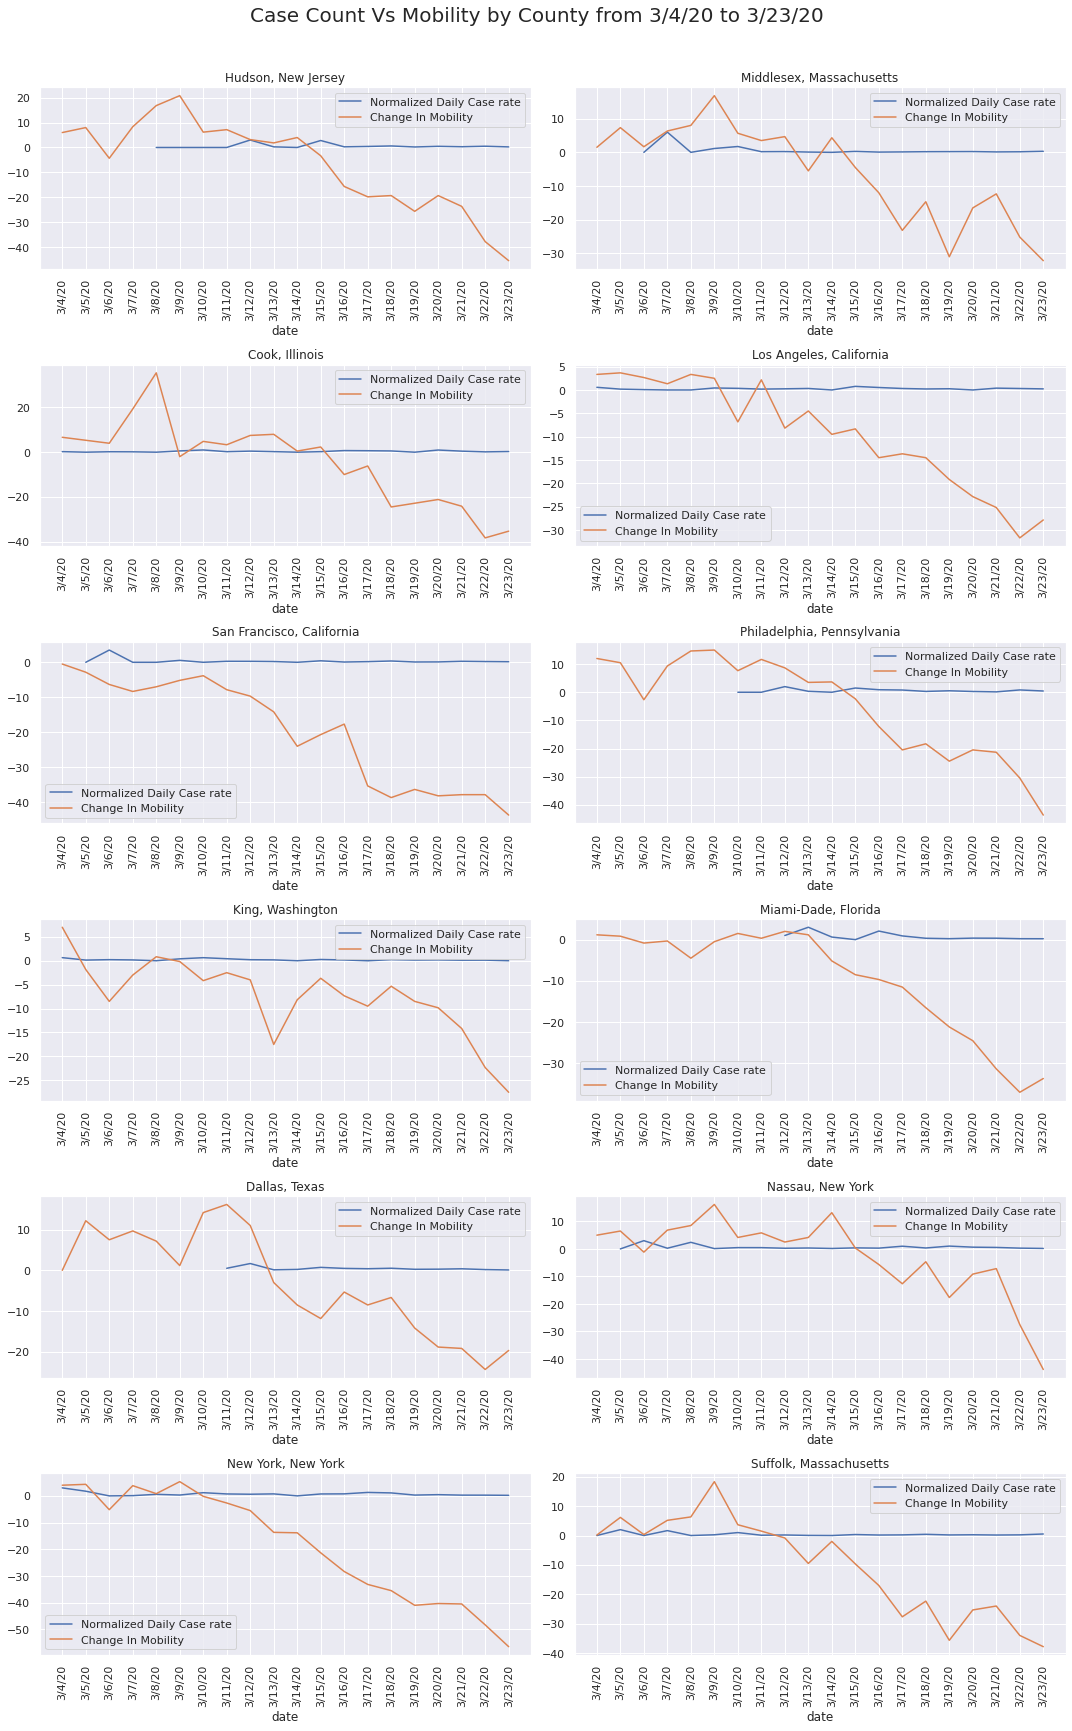

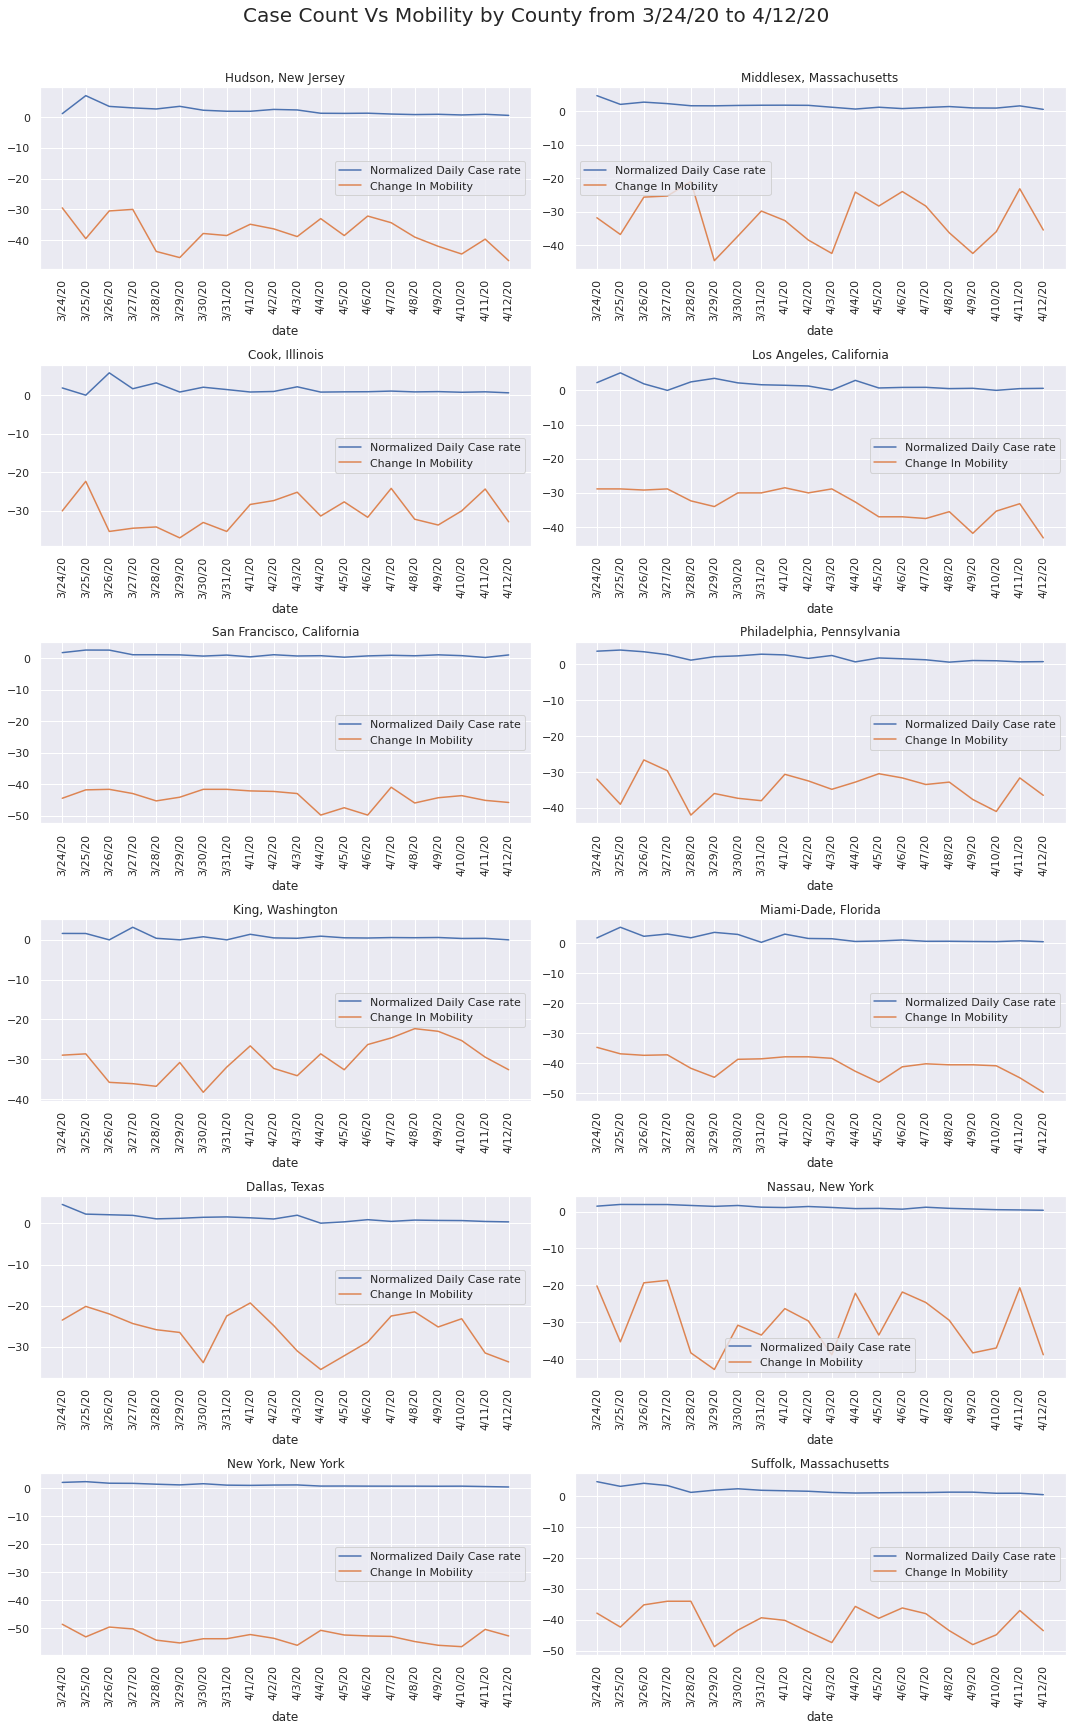

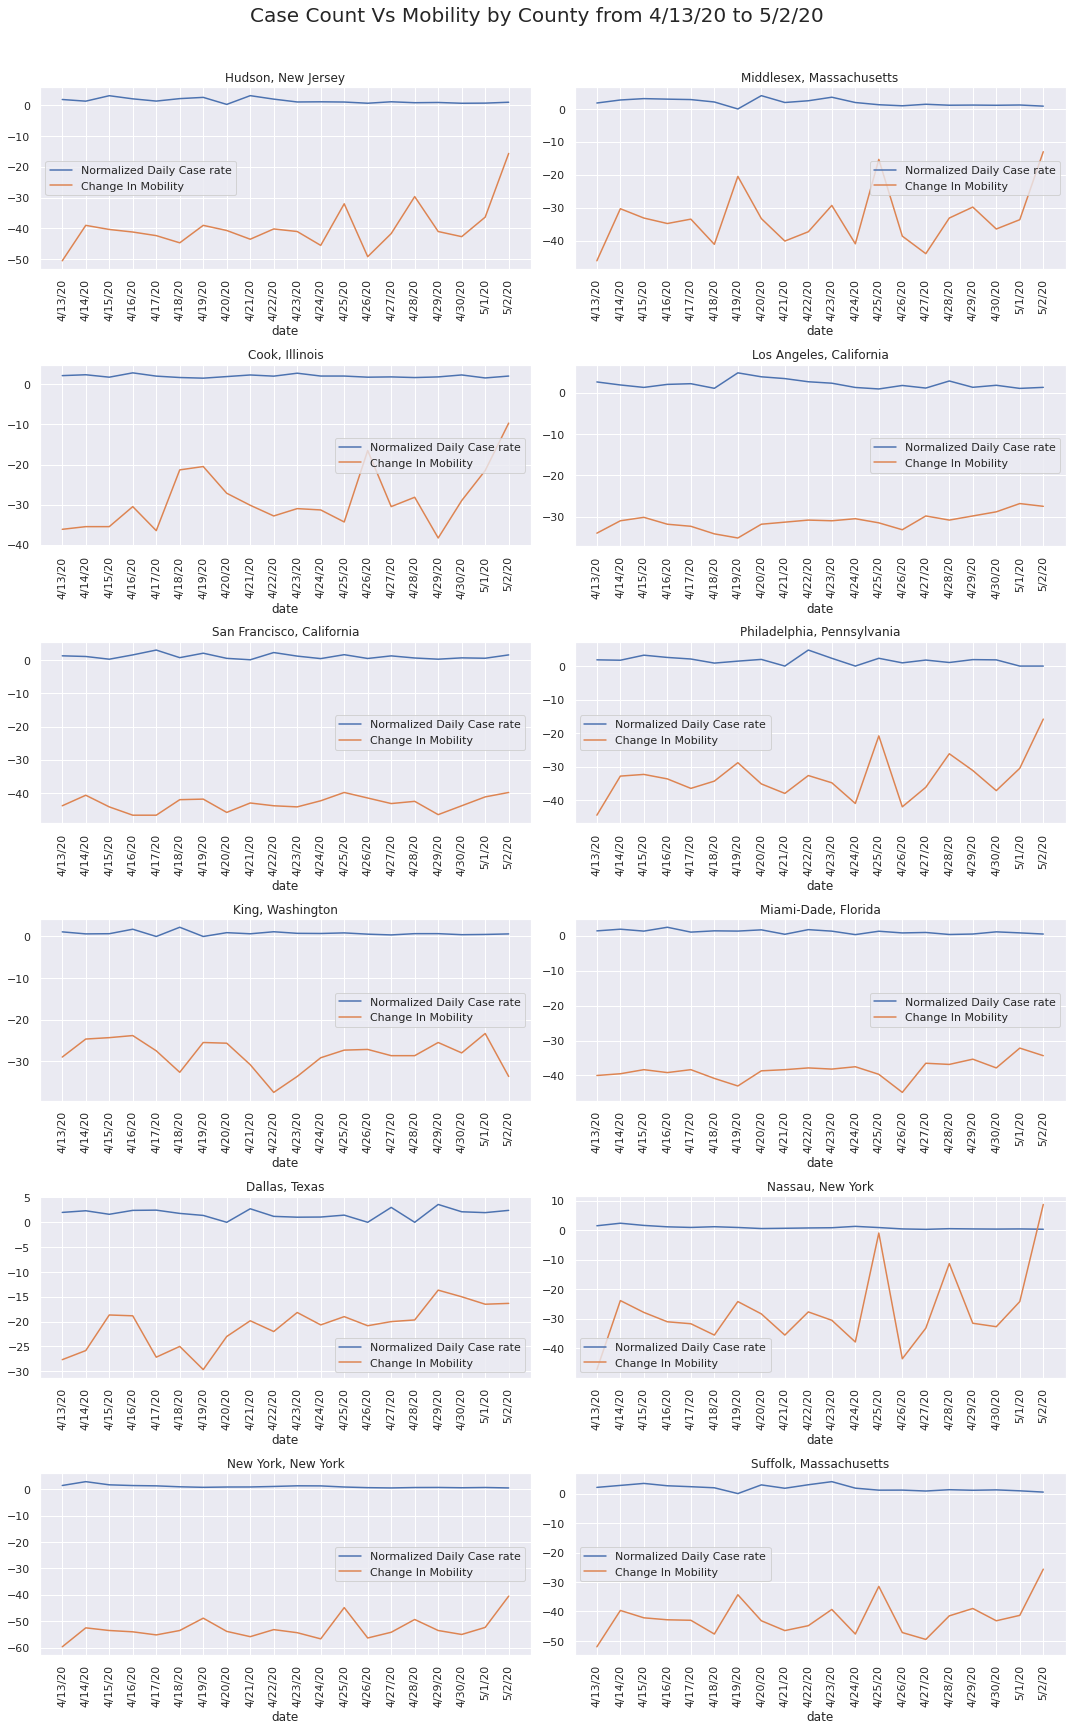

In [11]:
# Loop through dates and Fips

dates = [['3/4/20', '3/23/20'], ['3/24/20', '4/12/20'], ['4/13/20', '5/2/20']]
Fips = [34017, 25017, 17031, 6037, 6075, 42101, 53033, 12086, 48113, 36059, 36061, 25025] #26163

for j, date in enumerate(dates):
    fig, ax = plt.subplots(6,2, figsize=(15,25))
    ax = ax.flatten()
    for i, fips in enumerate(Fips):
        
        population = census.total_population.values[census.fips==fips]
        county = county_rate.loc[county_rate['FIPS'] == fips]
        mobil_county = final_df.loc[final_df['fips'] == fips]
        if j == 0:
            n = 1
        elif j ==1:
            n = 10
        else:
            n = 40
        ax[i].plot((county.loc[:, date[0]:date[1]].T)* n) 
#         ax[i].plot((county.loc[:, date[0]:date[1]].T/ population)/county[date[1]].values[0])
        ax[i].plot(mobil_county.loc[:, date[0]:date[1]].T)
#         case_slope = ((((county[date[1]].values[0]-county[date[0]].values[0])/population) / 20) / county[date[1]].values[0] )  # slop of case count during time period
        county_name = county.Admin2.values[0]
        state_name = county.Province_State.values[0]

        ax[i].set_xlabel('date')
    #     ax[i].set_ylabel('cases / population')
        ax[i].set_title(f'{county_name}, {state_name}')
        ax[i].legend(['Normalized Daily Case rate','Change In Mobility'])
        fig.suptitle(f'Case Count Vs Mobility by County from {date[0]} to {date[1]}', fontsize=20)

    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)

    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

#Plots comparing mobility to case rate of change

Part of our goal up to this point was obtain plots similar to the ones on page 14 of the [paper](https://arxiv.org/pdf/2004.09911.pdf). Here they plot the percentage of reduction in mobility against the reduction in fevers with each data point being it's own county. This is where our main changes are made to the methods used in the paper. We were very excited to see that despite not having access to the same mobility data and using the COVID data rather than overall fever, we were able to get similar results and regression trends for our data.




If you look at the plots and compare, the trend lines apear to be comparable despite being an entirely different metric. The paper has the points colored by the U.S. region they are located in. This was the source of our insperation to possibly take the research further. We noticed that modeling was very difficult and saw that prehaps an unsupervised approach would give us a chance to learn more from our data and try to get past some of the very stochastic aspects.

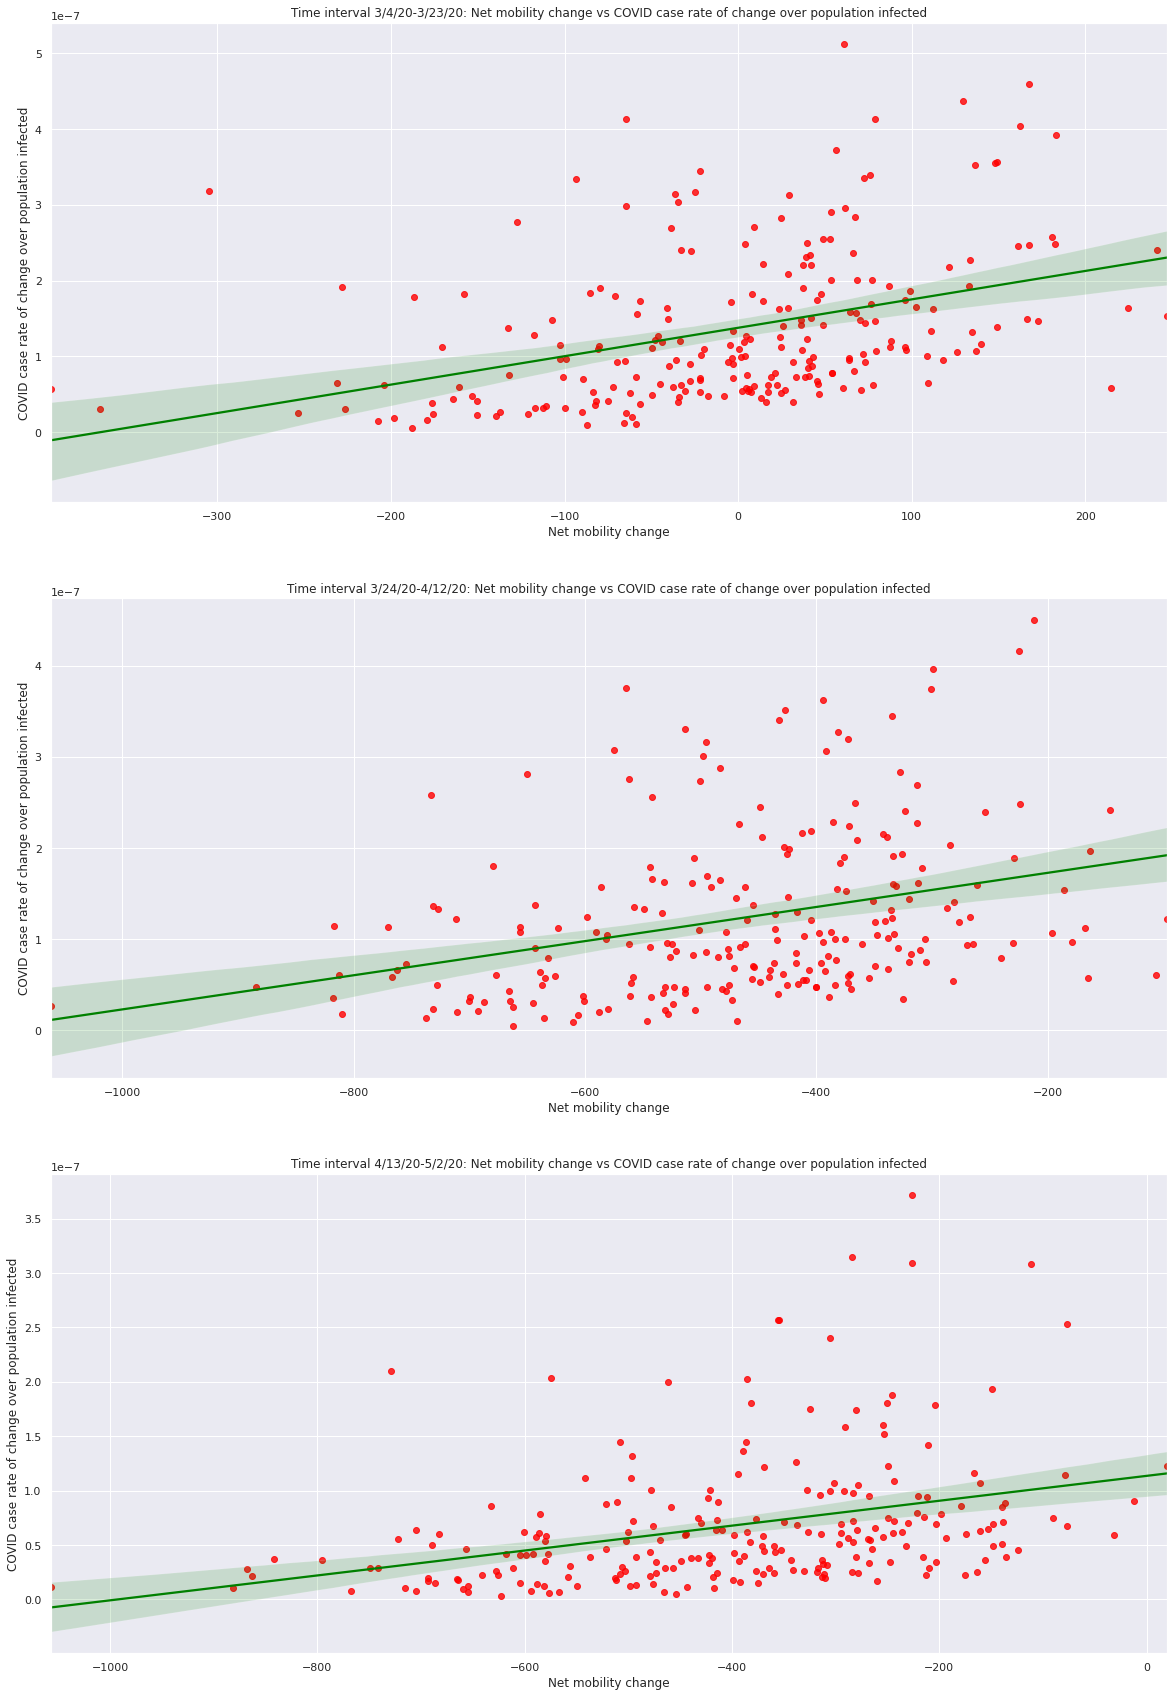

<Figure size 432x288 with 0 Axes>

In [12]:
mobile = ['total_1','total_2','total_3']
dates = ['3/4/20-3/23/20', '3/24/20-4/12/20', '4/13/20-5/2/20']
cases = ['case1','case2','case3']

fig, axes = plt.subplots(3,1,figsize=(20,30))

# loop through subplots and plot respective counties with trendlines
for i in range(3):
  axes[i].set_title('Time interval ' +  dates[i]  +  ': Net mobility change vs COVID case rate of change over population infected')
  sns.regplot(x=mobile[i], y=cases[i], data=final_df, ax=axes[i], scatter_kws={"color": "red"}, line_kws={"color": "green"});
  axes[i].set_xlabel('Net mobility change')
  axes[i].set_ylabel('COVID case rate of change over population infected')

fig = plt.figure();


#Clustering 




Overall for clustering we tried several different approaches but ultimately decided on a simple agglomarative clustering method. Originally we did a lot of work with DBSCAN but ultimetly it failed to give evenly distributed clusters. We had also attempted TSNE but decided on this as a better representation. This section only contatains a smaller part of the clustering we tried. For a much more detailed look at the github more specifically the TSNE_and_Heatmap.ipynb

Just a small added amount of data preproccessing to get it ready for clustering... Feel free to take a scroll through and see what features we chose for clustering. A description of some of these can be found on the github at analytic_data_dictionary

In [0]:
# census load and quick name change
census = pd.read_csv('https://raw.githubusercontent.com/GabrielBG010/Covid-County-Clustering/master/census_usa.csv')
census['county_name'] = census['name_x']
del census['name_x']

# merge one last time for number of points consistancy
combined2 = census.merge(final_df, on='county_name', how='inner')
combined2 = combined2.dropna()

# grab only the columns we want for clustering
cluster_df = combined2.iloc[:, 1 :-86]
cluster_df_fips = combined2.iloc[:, 0 :-86]

In [14]:
cluster_df.head()

,median_household_income,unemployment_rate_x,no_health_insurance_p,income_below_poverty_p,vacant_housing_units_p,median_home_value,over25_bachelors_or_higher_p,pop_foreign_born_p,households_with_internet_subscription_p,median_age,total_population,population_density,black_african_american_p,pop_per_sq_mile,housing_per_sq_mile,n_hospital_beds_2017,n_hospitals_2017,total_hosp_ftes_2017,n_active_mds_2017,n_hospital_admissions_2017,prev_hosp_stays_rate_2017,n_patient_days_short_term_2017,n_medicare_bene_2017,n_medicare_eligible_2018,n_airborn_infec_iso_rooms_2017,n_critical_access_hosp_2017,n_critical_access_st_gen_hosp_2017,n_fqhcs_2018,n_hosp_airborn_infec_iso_rooms_2017,n_hosp_with_ct_2017,n_hosp_with_ed_2017,n_hosp_with_telehealth_eicu_2017,n_hosp_with_urgent_care_2017,n_65yo_below_poverty_level_2017,n_65yo_below_deep_poverty_2017,n_people_below_poverty_level_2017,n_person_below_deep_poverty_level_2017,n_short_term_comm_hosp_2017,n_short_term_gen_hosp_2017,n_skilled_nursing_2017,...,n_nursing_home_beds_2017,p_nonwhite,p_white,prop_diabetes,CHD_hosp,ob_prev_adj,hypertension_hosp,prop_edu_less_high_school,prop_edu_less_college,prop_food_stamp_SNAP_recip,median_HHI,income_inequal,prop_poverty,unemployment_rate_y,annual_PM2.5,prop_uninsured,prop_medicaid_eligible,n_households,avg_hh_size,n_65_living_alone,p_65_living_alone,n_hh_grandparents_with_under18,p_hh_grandparents_with_under18,n_hh_with_computer,p_hh_with_computer,n_hh_with_broadband,p_hh_with_broadband,n_usa_native,p_usa_native,gini_coef,p_hh_renter,ice_wb_income,p_group_quarters,premature_mort,severe_housing_problems,severe_housing_cost_burden,p_crowded_housing,high_housing_cost,empower_medicare_bene,empower_power_depend
0,45566,9.6,15.8,20.1,14.3,144500,22.3,4.8,76.8,36.0,202626,1.36,24.3,326.0,148.4,1282,7,216,413,39905,6312.0,226509,27214.0,40890.0,33,0,0,11.0,2,2,2,0,0,2812,843,39854,20847,4,5,7.0,...,0.0,35.196225,64.803775,10.4,99.1,34.0,177.4,13.0,77.8,20.4,43.0,0.443,20.5,5.1,9.8,15.4,21.5,78863.0,2.51,8377.0,10.6,4646.0,5.891229,66891.0,84.8,60554.0,76.8,192846.0,95.2,0.4581,44.0,0.021125,0.024385,9924.217626,0.192673,0.167420,3.289965,27113.0,38326.0,2342.0
1,65300,5.2,6.7,9.7,8.3,190100,43.2,7.3,84.7,40.3,998684,7.60,24.0,1967.2,862.6,4192,15,1610,5059,179356,4471.0,868657,103626.0,210733.0,217,0,0,8.0,10,10,10,3,6,9897,3552,95974,41832,13,10,69.0,...,252.0,33.451093,66.548907,9.7,74.3,28.9,152.6,6.8,57.2,10.9,62.8,0.488,9.2,3.9,12.1,8.1,14.6,403547.0,2.43,50264.0,12.5,16220.0,4.019358,365989.0,90.7,341633.0,84.7,926072.0,92.7,0.4904,31.0,0.204762,0.018812,7511.027891,0.141362,0.123207,1.028568,112627.0,191287.0,6434.0
2,54043,4.3,7.0,18.3,8.2,179800,46.0,6.6,82.7,30.8,176515,0.99,8.8,237.3,101.5,1134,5,206,1428,46743,3261.0,236679,15950.0,27805.0,85,0,0,2.0,3,3,3,1,2,1269,362,30979,17068,3,3,10.0,...,35.0,20.297214,79.702786,7.8,60.2,26.7,127.9,6.5,54.1,9.9,52.8,0.476,16.6,2.9,10.1,9.2,14.5,69957.0,2.39,5726.0,8.2,2440.0,3.487857,65373.0,93.4,57848.0,82.7,164840.0,93.4,0.4673,44.7,0.179610,0.051605,5623.013157,0.179681,0.160731,1.425295,20938.0,25330.0,1241.0
3,52805,5.1,11.6,15.2,11.8,139000,30.9,5.8,78.7,36.7,692003,4.42,23.4,1115.3,516.3,3055,15,6696,2106,125188,5346.0,610743,62498.0,129081.0,129,0,0,16.0,8,9,9,1,1,8056,2263,108026,49617,10,10,39.0,...,498.0,36.494709,63.505291,10.2,86.6,32.5,184.9,10.1,69.8,16.0,50.8,0.467,15.5,4.6,10.4,11.5,22.5,282653.0,2.41,29609.0,10.5,12655.0,4.477221,246886.0,87.3,222324.0,78.7,651534.0,94.2,0.4657,41.5,0.095676,0.016728,8757.898948,0.171212,0.144321,1.602933,85792.0,114257.0,5964.0
4,61155,5.6,10.2,12.2,8.4,299400,30.5,14.0,83.4,38.1,450486,0.28,2.1,66.9,29.3,1714,11,1461,1351,59717,3166.0,309245,49219.0,91418.0,61,1,1,11.0,2,4,4,0,0,5147,1835,58642,27326,6,6,8.0,...,60.0,35.829388,64.170612,6.7,50.9,22.8,119.3,12.4,70.2,12.8,58.3,0.463,12.5,3.9,8.4,11.7,13.3,177632.0,2.50,19442.0,10.9,8900.0,5.010358,162874.0,91.7,148196.0,83.4,387268.0,86.0,0.4581,42.0,0.229790,0.013303,7089.039609,0.214975,0.147849,4.420842,58193.

Here we try out some PCA to get a sense of how much of our varience can be explained based on the number of components.

In [0]:
# scale the values before PCA
x = cluster_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=cluster_df.columns)

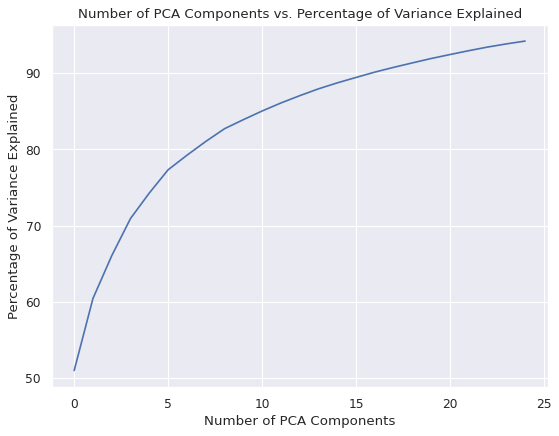

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


X = df
scores = []

# loop through  PCA components fit pca and get variance ratio
for i in range(25):
  pca = PCA(n_components=i+2)
  pca.fit(X)
  X_pca = pca.transform(X)
  scores.append(round(sum(pca.explained_variance_ratio_)*100,3))
plt.xlabel('Number of PCA Components')
plt.ylabel('Percentage of Variance Explained')
plt.title('Number of PCA Components vs. Percentage of Variance Explained')
plt.plot(scores);

In the end we settled on 20 because it seems to explain a good amount varience and reduces the dimensionality of our data a lot.

In [17]:
# PCA to be used for clustering
pca = PCA(n_components=20)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
print('Explained variance total: ' + str(round(sum(pca.explained_variance_ratio_)*100,3)) + '%')

original shape:    (224, 143)
transformed shape: (224, 20)
Explained variance total: 91.344%


In [0]:
# Calculation of the cluster labels
clustering = AgglomerativeClustering(5).fit(X_pca)
clustering.labels_
#Plot of the PCA result
plt.scatter(X_pca[:, 0],X_pca[:, 1],c=clustering.labels_)

The following section shows how we clustered the information. In order to do that, we compute a different representation by using PCA, triying to maximize the variance explained, and the we use AgglomerativeC lustering to determine the best way to group the information.

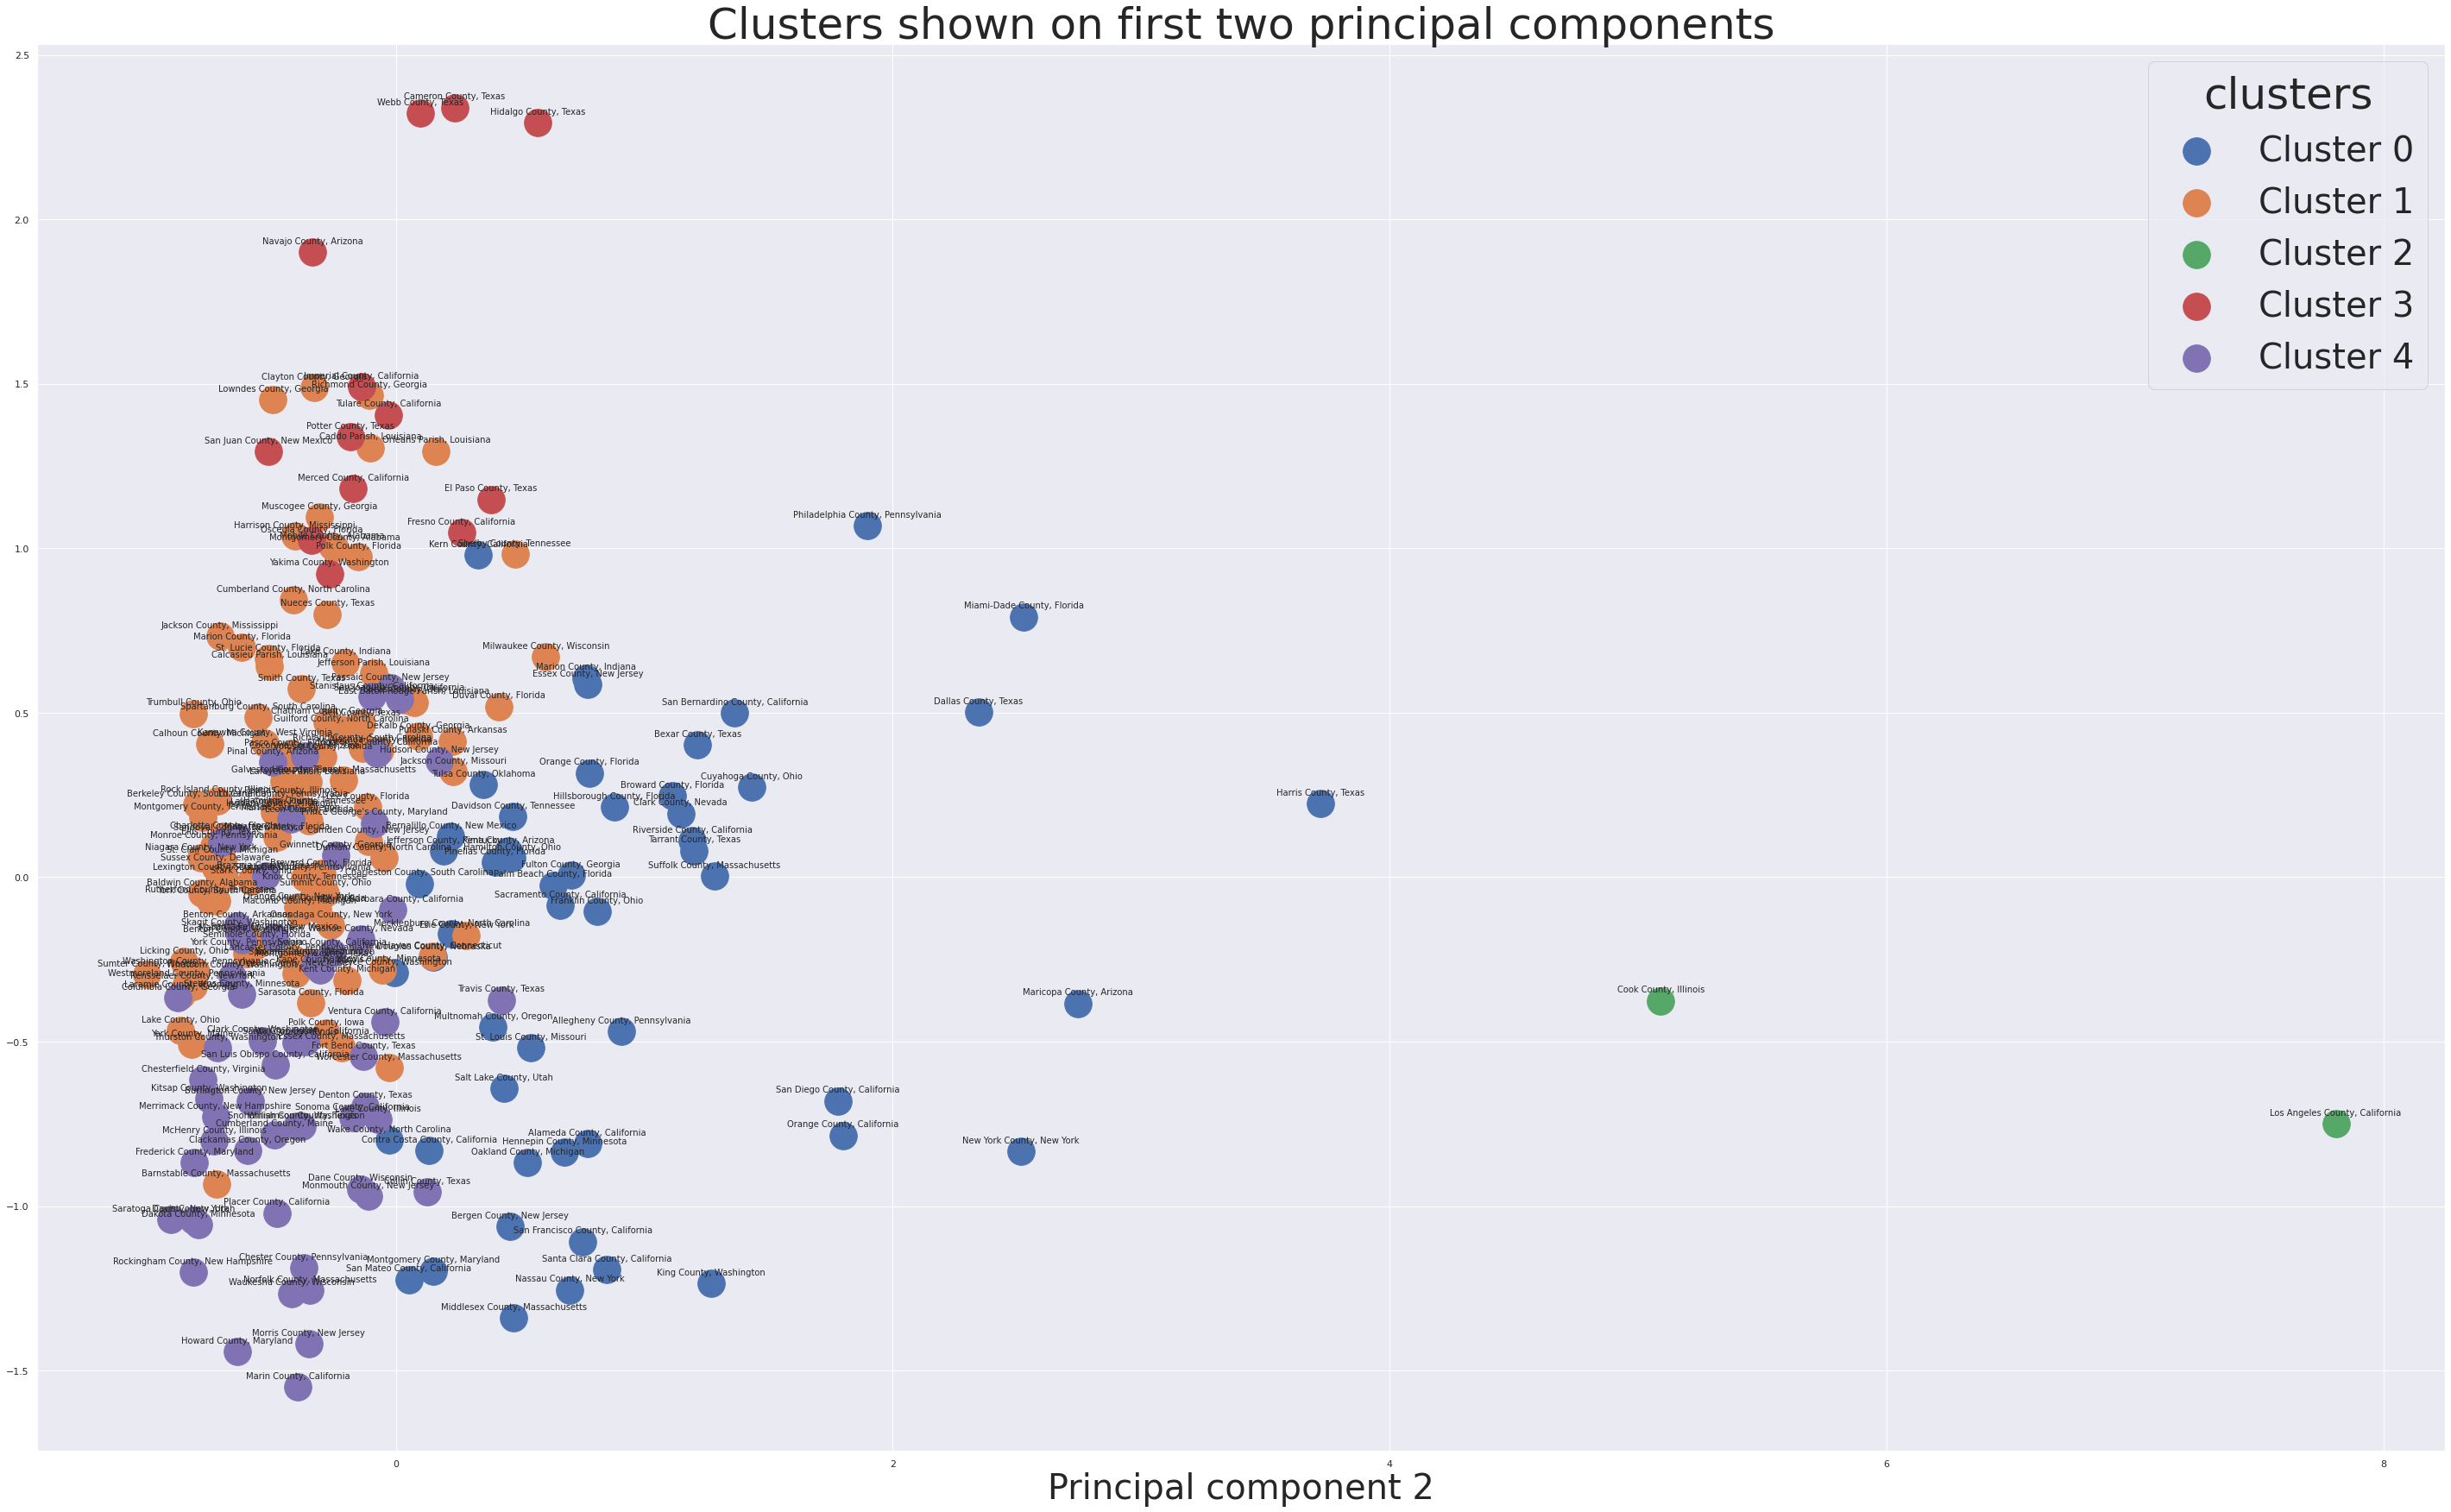

In [40]:
# ScatterPlot of the 2 main principal components and
# different colors means a different cluster.

plt.figure(figsize=(50, 30))

for i in range(max(clustering.labels_)+1):
  plt.scatter(X_pca[:, 0][clustering.labels_==i],X_pca[:, 1][clustering.labels_==i],label="Cluster {:g}".format(i),marker='o',s=1000)

# Labels for the plot
county_name = combined2['county_name'] 
i = 0

# Insertion of County names
for x,y,name in zip(X_pca[:, 0],X_pca[:, 1],county_name):
  plt.annotate(name,
                  (x,y), 
                  textcoords="offset points", 
                  xytext=(0,10),
                  ha='center')
  i+=1

plt.legend(title='clusters',title_fontsize=50,fontsize=40);

plt.xlabel('Principal component 1', fontsize=40)
plt.xlabel('Principal component 2', fontsize=40)
plt.title('Clusters shown on first two principal components', fontsize=50);

Above we observe what apears to be a reasonable amount of clusters. We noticed here the green cluster is only two examples. Those counties correspond to Chicago and L.A. We have encountered similar results before where large cities seem to behave in a different way than the average county.

In [0]:
# Load of raw data
confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
death_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
confirmed_raw = confirmed_raw.set_index('FIPS')
death_raw = death_raw.set_index('FIPS')

In [0]:
# Data treatmend for the death rate.
# We chose to compute this value as 7-day average of the daily death rate
death = death_raw.drop(death_raw.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis = 1 )
death = death.reset_index().dropna()
death = death.astype({'FIPS': 'int32'})
death = death.set_index('FIPS')
d7 =  pd.DataFrame(death.T.diff().rolling(7).mean().mean(),columns=['death_rate'])

# Data treatmend for the confirmed cases.
# We chose to compute this value as 7-day average of the daily confirmed cases
confirmed = confirmed_raw.drop(confirmed_raw.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis = 1 )
confirmed = confirmed.reset_index().dropna()
confirmed = confirmed.astype({'FIPS': 'int32'})
confirmed = confirmed.set_index('FIPS')
c7 =  pd.DataFrame(confirmed.T.diff().rolling(7).mean().mean(),columns=['number_of_cases'])

In [0]:
# Data augmentation of the dataset previously used to 
# add the cluster for each observation
cluster_df_fips = cluster_df_fips.set_index('fips_x')

In [0]:
final_df = cluster_df_fips.join(c7).join(d7).reset_index().drop(columns='fips_x')

In [0]:
final_df2 = final_df.copy()
lbl = np.array(clustering.labels_ )
for c in range(clustering.labels_.max()+1):
  final_df2["cluster"+str(c)] = np.where(lbl==c,1,0)

# Plots after clustering

Below is a function that will plot the same regression plots earlier except this time the regressions and labelings will be based off of the clusters. The function is generic and will take in any amount of clusters and output the corresponding plot. 

In [0]:

def plot_clusters(labels):
  """
  Function to plot clusters with individual reggression plots
  Parameters:
    labels: these are cluster labels drom sklearn
  """

  mobile = ['total_1','total_2','total_3']
  dates = ['3/4/20-3/23/20', '3/24/20-4/12/20', '4/13/20-5/2/20']
  cases = ['case1','case2','case3']

  fig, axes = plt.subplots(3,1,figsize=(20,30))

  combined2['clusters'] = labels

  # group by cluster for itteration
  grouped = combined2.groupby('clusters')

  # Loop through time period first
  for i in range(3):
    # loop through group
    for name, group in grouped:
      # plot respective cluster with regression line
      axes[i].set_title('Time interval ' +  dates[i]  +  ': Net mobility change vs COVID case rate of change over population infected')
      sns.regplot(x=mobile[i], y=cases[i], data=group, ax=axes[i])
      axes[i].set_xlabel('Net mobility change')
      axes[i].set_ylabel('COVID case rate of change over population infected')

    # make legend
    axes[i].legend(range(name+1),title='Cluster', fancybox=True, loc="upper right")


These plots are great to look at and validates the hard work it took to get all of this data together and cluster. Some observations are that cluster 0 (blue) has a very tight confidence interval but apears to have slightly weaker correlation. In contrast cluster 3 (red) has the steepest regression line but the widest interval. We are not exactly sure what could potentially explain this phenomenon but believe it could have something to due with the number of data points in the cluster being much smaller than the others (but then again green may be a different case because it only has two points). Something also of interest is that we don't see any cluster with negative slope regression lines. This was interesting and reaffirms the relationship shown in earlier plots.

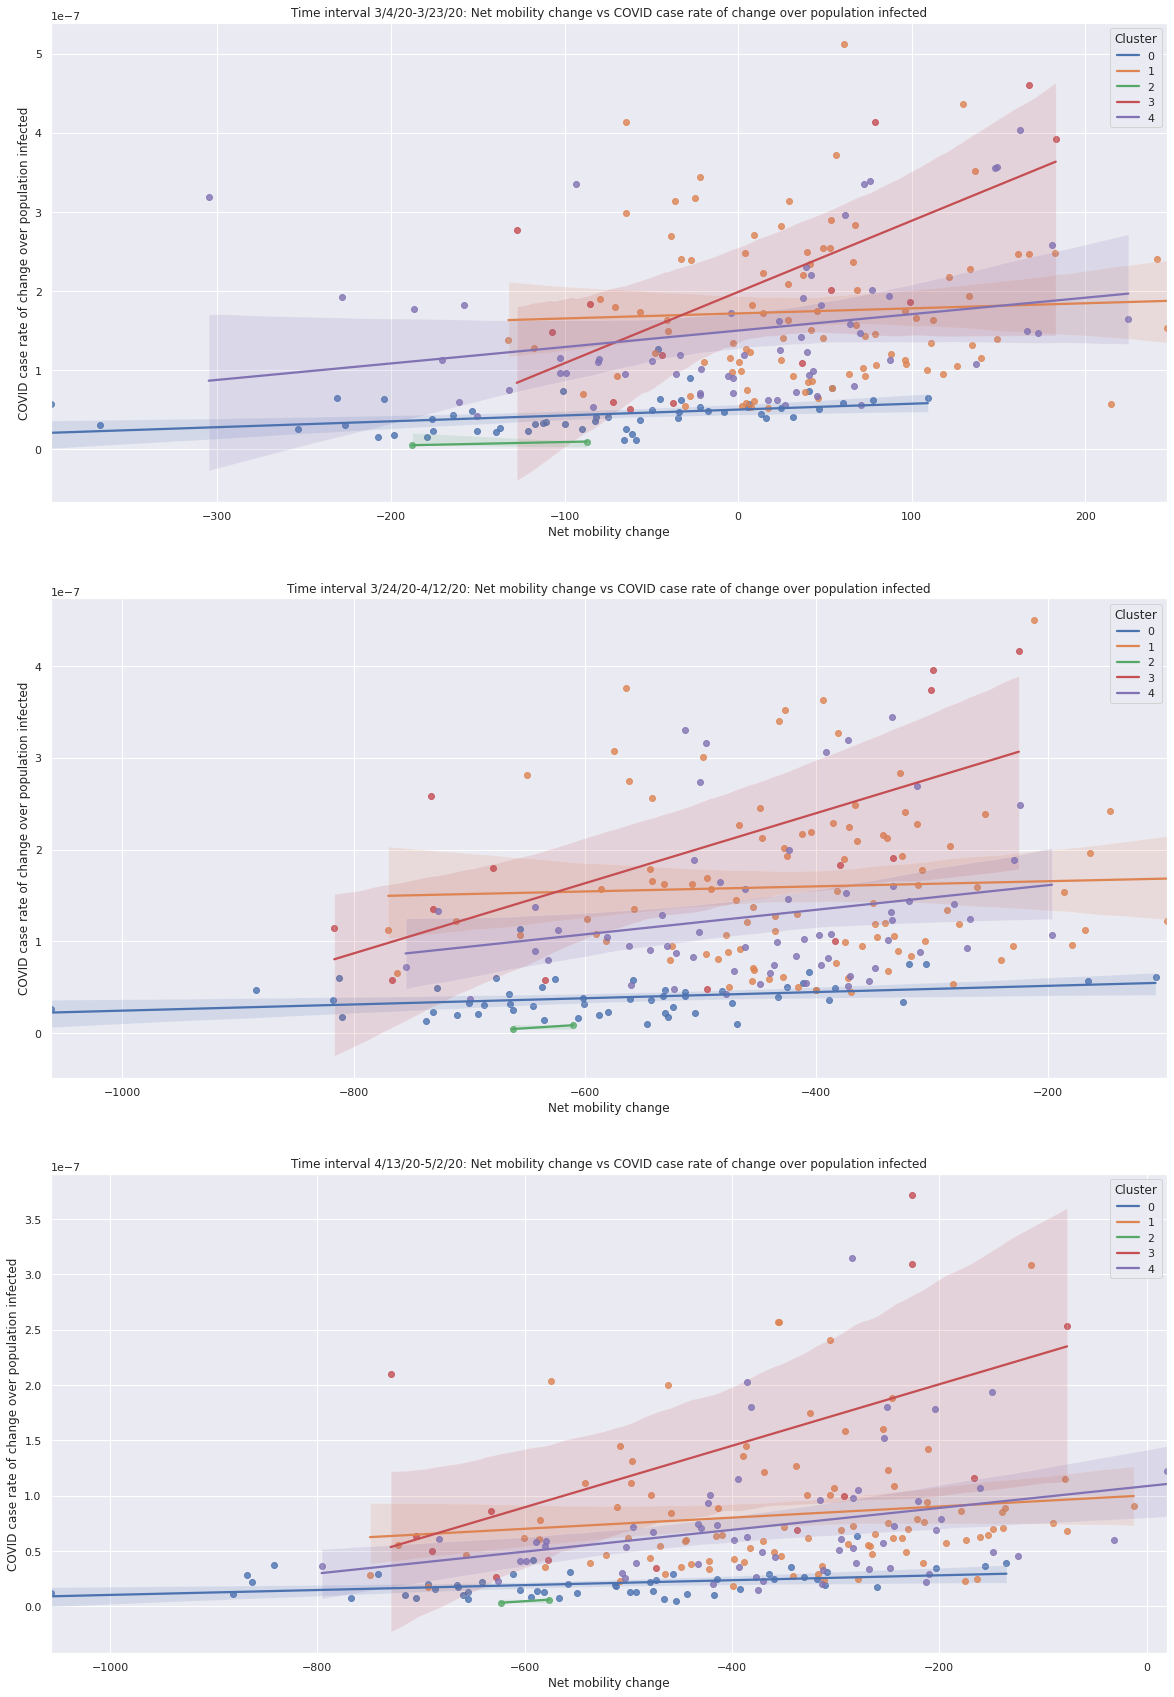

In [27]:
plot_clusters(label)

There also doesn't seem to be a large amount of change between the time intervals chosen which shows this relationship may not be super dependent on which interval is chosen.



# Heat map of census attribute correlation divided into clusters

This is a large source of our analysis and where we can draw most of our conclusions from. The idea here is to hopefully isolate some interesting cluster correlations from the regression plots above and use the census heat maps below to ultimetly draw conclusions on the mobility/COVID relationship.

In [0]:
def plot_heat_map(h):
  """
  Function to plot a heatmap
  Parameters:
    h: Dataset to plot (usually a correlation matrix)
  """
  fig, ax = plt.subplots(figsize=(6,4*h.shape[0]//3))

  ax = sns.heatmap(
      h, 
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(240, 10, n=9),
      ax=ax
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

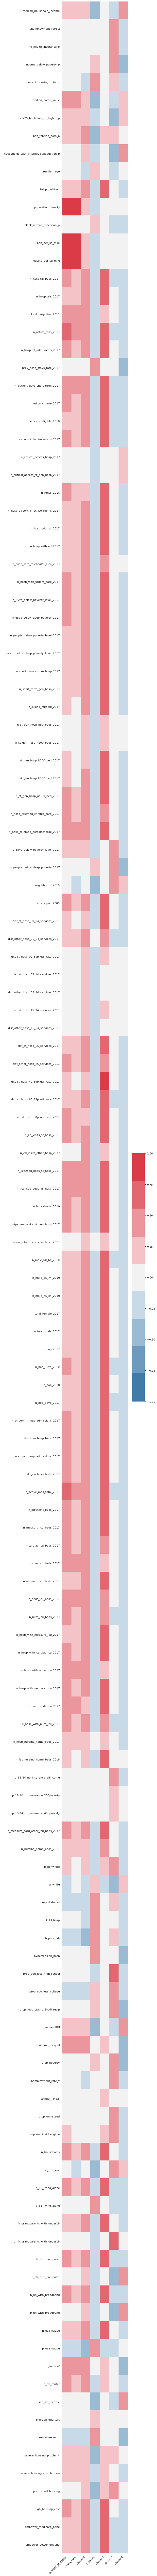

In [44]:
# Correlation matrix of all the data
corr = final_df2.corr()
# Subsetting of the death rate, cases and cluster information.
corr = corr.iloc[:-7,-7:]
# Plot of the correlation Matrix
plot_heat_map(corr)

# Analysis of results and methods

## Analysis

Overall, our data shows that a reduction in mobility indicates a reduction in cases. With some clusters embodying this trend more than others. We also see which cluster your county belongs to has a stronger correlation.

Our results are showing that as counties improve their social distancing by reducing their mobility than it will have a positive affect on the spread of COVID-19. Another important finding is that depending on which cluster your county belongs to the amount that social distancing measures affected the spread of the virus will be greatly impacted. Thus, it is really important to understand which cluster your county belongs to if you want to know how strict your social distancing measures should be. Those that have a strong a correlation between distancing measure and spread of mobility can begin to reduce their social distancing efforts in order to help stimulate the economy towards going back to normal economic conditions. If they have reduced the spread significantly. On the other hand, if reducing mobility has not had as great an impact in your county in slowing the spread of COVID-19 than other measures should be considered.

One notable but not suprising thing we observed was the dark red squares for population per square mile, population density, and housing per square mile. This was not a suprise, it is to be expected that high population density has a stong influence on the spread of disease. It was nice to see this though as it is a little bit of a sense check that our clusters are doing something meaningful.


Some other results that we found were of the same nature in the sense that they were not suprising. For example, we observed strong correlations in census attributes related to age, more specifically categories related to ages 65 and over.

## Methods

# Refrences

1.	Chin, Taylor, et al. “U.S. County-Level Characteristics to Inform Equitable COVID-19 Response.” Nov. 2020, doi:10.1101/2020.04.08.20058248.

2.	Johnson A, Buford T. Early Data Shows African Americans Have Contracted and Died of Coronavirus at an Alarming Rate [Internet]. ProPublica. ProPublica; 2020 [cited 2020 Apr 4]. Available from:https://www.propublica.org/article/early-data-shows-african-americans-have-contracted-and-died-of-coronavirus-at-an-alarming-rate

3.	Eligon J, Burch ADS, Searcey D, Oppel Jr. RA. Black Americans Face Alarming Rates of Coronavirus Infection in Some States. The New York Times [Internet]. 2020 Apr 7 [cited 2020 Apr7]; Available from: https://www.nytimes.com/2020/04/07/us/coronavirus-race.html

4.	Wu Z, McGoogan JM. Characteristics of and Important Lessons From the Coronavirus Disease 2019 (COVID-19) Outbreak in China: Summary of a Report of 72 314 Cases From the Chinese Center for Disease Control and Prevention. JAMA [Internet]. 2020 Feb 24 [cited 2020 Mar 17]; Available from: https://jamanetwork.com/journals/jama/fullarticle/2762130

5.	CDCMMWR. Severe Outcomes Among Patients with Coronavirus Disease 2019 (COVID-19) — United States, February 12–March 16, 2020. MMWR Morb Mortal Wkly Rep [Internet]. 2020 [cited 2020 Mar 18];69. Available from: https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm

6.	Li W, Lewis N. This Chart Shows Why The Prison Population Is So Vulnerable to COVID-19 [Internet]. The Marshall Project. 2020 [cited 2020 Mar 23]. Available from: https://www.themarshallproject.org/2020/03/19/this-chart-shows-why-the-prison-population-is-so-vulnerable-to-covid-19

7.	Barnett ML, Grabowski DC. Nursing Homes Are Ground Zero for COVID-19 Pandemic. JAMA Health Forum. 2020 Mar 2;1(3):e200369–e200369.

8.	Liautaud, Parker, et al. “Fever and Mobility Data Indicate Social Distancing Has Reduced Incidence of Communicable Disease in the United States.” ArXiv.org, 22 Apr. 2020, arxiv.org/abs/2004.09911.


9.	Dredze, M., Cheng, R., Paul, M.J. and Broniatowski, D., 2014, June. HealthTweets. org: a platform for public health surveillance using Twitter. In Workshops at the Twenty-Eighth AAAI Conference on Artificial Intelligence.

10.	Lampos, V., Moura, S., Yom-Tov, E., Cox, I.J., McKendry, R. and Edelstein, M., 2020. Tracking COVID-19 using online search. arXiv preprint arXiv:2003.08086.

11. Liautaud, P., Huybers, P. and Santillana, M., 2020. Fever and mobility data indicate social distancing has reduced incidence of communicable disease in the United States. arXiv preprint arXiv:2004.09911.

12.	Liu, D., Clemente, L., Poirier, C., Ding, X., Chinazzi, M., Davis, J.T., Vespignani, A. and Santillana, M., 2020. A machine learning methodology for real-time forecasting of the 2019-2020 COVID-19 outbreak using Internet searches, news alerts, and estimates from mechanistic models. arXiv preprint arXiv:2004.04019. 

13.	Lu, F.S., Hattab, M.W., Clemente, C.L., Biggerstaff, M. and Santillana, M., 2019. Improved state-level influenza nowcasting in the United States leveraging Internet-based data and network approaches. Nature communications, 10(1), pp.1-10.

14.	Menkir, T.F., Chin, T., Lipsitch, M., Niehus, R., Hay, J.A., Surface, E., de Salazar, P.M., Buckee, C., Mina, M.J., Khan, K. and Watts, A., 2020. Estimating the number of undetected COVID-19 cases exported internationally from all of China. medRxiv. https://www.medrxiv.org/content/10.1101/2020.03.23.20038331v2.full.pdf





# Conclusion

conclusion